In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from openai import OpenAI
import json
import os

#s.environ['HACKATHON_API_KEY'] = "KEY"

In [23]:
def load_data(file_path):
    return pd.read_csv(file_path)


def filter_data(df, start_time, frame):
    def generate_range(start_time, frame):
        dtStart = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        dtDiff = timedelta(hours=frame[0], minutes=frame[1])
        dest = dtStart + dtDiff
        return [start_time, dest.strftime('%Y-%m-%d %H:%M:%S')]
    
    time_range = generate_range(start_time, frame)
    return df[(df["time"] >= time_range[0]) & (df["time"] <= time_range[1])]

def initialize_api_client(api_key):
    return OpenAI(
        base_url="https://hackathon.radiantai.com/insight-ops/openai",
        api_key=api_key
    )


In [24]:


def process_post(context, post, api_client):
    
    system_prompt = """You are a helpful assistant designed to output JSON.
Your task is to extract information from social media posts or announcements relevant to the Ukraine Russian war and convert it into a graph database.

Here is how the graph database works:
Every object has a title and it has a type, the title indicates the name of the subject: this can be an person or "actor", event, or even concept, just make up a classification that is very standard.
Two objects may be related in some way and this may and in this case, you will add them to the relationships list, try to find fitting relationships between related objects. For example, if you create a relationship between a person and an event you can use the relationship "participated in" or "attended". Or if you have a person and a concept you can use "knows" or "is familiar with". Or if you have two events you can use "happened before" or "happened after". Make up a relationship.
How you will enter it in to the graph database it as follows:
{
  "subjects": [
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    ...
  ],
  "relationships": [
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    ...
  ]
]
If you can't pair a relationship with a pair of nodes don't add it.
When you find a node or relationship you want to add try to create a generic PROPERTY for it that describes the entity you can also think of it as a label.
Only include things relevant to the {context} if a relationship between two subject is purley a grammatical description or not relevant to the context of the {context} don't include it.
Also make sure that the RELATIONSHIP is consise, if the relationship is not simple to explain, it may not be relevant to the context of the {context} and should be left out."""

    
    response = api_client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Here's the post: {post} \\n Make sure to output in a JSON with the top level keys 'subjects' and 'relationships'"}
        ]
    )
    return json.loads(response.choices[0].message.content)

def extract_graph_data(df, api_client):
    """
    Iterate over a DataFrame of posts, process each one, and accumulate the graph data.
    
    Args:
    df (pandas.DataFrame): DataFrame containing the posts to process.
    api_client (OpenAI.Client): The API client instance.
    
    Returns:
    dict: A dictionary containing accumulated nodes and edges from all posts.
    """
    system_prompt = "Your task is to extract information from social media posts and convert it into a graph database."
    all_data = {'subjects': [], 'relationships': []}  # Initialize structure to hold combined data from all posts
    
    for index, row in df.iterrows():
        
        post_data = process_post("Russia vs. Ukraine", row['translation'], api_client)
        
        for x in post_data['subjects']:
            x[0] = row['id'] + '_' + str(x[0])
            
        for x in post_data['relationships']:
            x[0] = row['id'] + '_' + str(x[0])
            x[2] = row['id'] + '_' + str(x[2])
            
        
        all_data['subjects'].extend(post_data['subjects'])
        all_data['relationships'].extend(post_data['relationships'])
    
    return all_data




In [47]:
api_key = os.environ["HACKATHON_API_KEY"]
df = load_data('data/russia_social_media.csv')


In [48]:
filtered_df = filter_data(df, "2024-03-31 18:00:00", [0, 1]).head(5)
api_client = initialize_api_client(api_key)

In [49]:
structured_data = extract_graph_data(filtered_df, api_client)

In [74]:
expost = filtered_df['translation'][filtered_df.index[0]]
print(expost)
file_key = filtered_df['attachment_urls'][filtered_df.index[0]]
#expost = "The Russian military has launched a full-scale invasion of Ukraine, with troops crossing the border in multiple locations. The attack began at 5 a.m. local time, with reports of explosions and gunfire in several cities. Ukrainian President Volodymyr Zelensky has declared martial law and called on citizens to defend their country. The international community has condemned the invasion, with the U.S. and EU imposing sanctions on Russia. The conflict has raised fears of a wider war in Europe and a humanitarian crisis in Ukraine."
excontext = "Russia vs. Ukraine"
eximg_url = "https://vl-nat-sec-hackathon-may-2024.s3.amazonaws.com/" + file_key
#eximg_url = "https://upload.wikimedia.org/wikipedia/commons/a/ac/A_Russia-backed_rebel_armored_fighting_vehicles_convoy_near_Donetsk%2C_Eastern_Ukraine%2C_May_30%2C_2015.jpg"
def interpret_image(image_url, context, post, api_client):
  post_contents = process_post(context, post, api_client)
  print(post_contents)
  system_prompt = """You are a helpful assistant designed to output JSON and analyze images. This image in the user message was attached to a post. We had a program analyze the post and come up with subjects and relationships/actions between those subjects. You will be provided that data of the subjects and relationships, the context of the post to mkae sure you do not mention anything irrelevant. You need to do the following:
  Analyze the image and provide the subjects and relationships/actions between those subjects to enter into the graph database.
  MAKE SURE to output the data in a JSON format with the top level keys 'subjects' and 'relationships', 
  Every object has a title and it has a type, the title indicates the name of the subject: this can be an person or "actor", event, or even concept, just make up a classification that is very standard.
  Two objects may be related in some way and this may and in this case, you will add them to the relationships list, try to find fitting relationships between related objects. For example, if you create a relationship between a person and an event you can use the relationship "participated in" or "attended". Or if you have a person and a concept you can use "knows" or "is familiar with". Or if you have two events you can use "happened before" or "happened after". Make up a relationship.
  How you will enter it in to the graph database it as follows, only include finding from the image in this response (meaning you will output in JSON format, DO NOT OUTPUT ANYTHING ELSE, IT WILL BREAK THE WHOLE PROGRAM):
  {
    "subjects": [
      [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
      [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
      ...
    ],
    "relationships": [
      [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
      [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
      ...
    ]
  }
  When you find a node or relationship you want to add try to create a generic PROPERTY for it that describes the entity you can also think of it as a label.
  Include things relevant to the""", context, """. 
  Also make sure that the RELATIONSHIP is consise, if the relationship is not simple to explain, it may not be relevant to the context of the""", context, """and should be left out. Analyze the image in keeping in mind the similarity and relevance of it to the QUALITIES OF THE PREVIOUS MOST HERE: """, str(json.dumps(post_contents)) , """and provide the JSON response, remember to look at the subjects of the post it is attached to, if there is something potentially related to a subject in the post, include it in the response."""

  response = api_client.chat.completions.create(
    model='gpt-4-vision-preview',
    messages=[
      {'role': 'system', 'content': system_prompt},
      {'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': image_url}}]}
    ]
  )
  
  return json.loads("".join((response.choices[0].message.content).split("\n")[1:-1]))

print(interpret_image(eximg_url, excontext, expost, initialize_api_client(os.environ["HACKATHON_API_KEY"])))

✔️No elections✔️No Crimea✔️No Donbass✔️No future

Even the crests themselves will soon end.
{'subjects': [[1, 'No elections', 'concept'], [2, 'No Crimea', 'concept'], [3, 'No Donbass', 'concept'], [4, 'No future', 'concept'], [5, 'crests', 'actor']], 'relationships': []}
{'subjects': [[6, 'Advertisement', 'object'], [7, 'Graffiti', 'object'], [8, 'Building', 'structure'], [9, 'Political statement', 'concept']], 'relationships': [[7, 'is located on', 8, {'Descriptive': 'The graffiti is spray-painted on the wall of the building'}], [7, 'contrasts with', 6, {'Descriptive': 'The graffiti presents a contrasting sentiment to the advertisement'}], [7, 'expresses', 9, {'Descriptive': 'The graffiti expresses a political statement'}]]}


In [29]:
def create_graph(data):
    G = nx.DiGraph()
    for node in data['subjects']:
        node_id, name, node_type = node
        print(name)
        G.add_node(node_id, name = name, node_type = node_type)
        
    for edge in data['relationships']:
        source, relation, target, props = edge
        G.add_edge(source, target, relation=relation)
    return G

def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=5, edge_color='gray', width=2)
    node_labels = {node: G.nodes[node]['name'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    edge_labels = {(u, v): data['relation'] for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

In [30]:
G = create_graph(structured_data)

No elections
No Crimea
No Donbass
No future
crests
Moscow
Kiev regime
Krasnopol
Seizure of power in Ukraine
Macron
Belgian television
Severe fire in the Krasnodar region
Fearless doctors
KTOv Dagestan
Germany
Taurus
Paris
Russophobe
Russian Foreign Ministry
Former 'traditions'
Soyuz-2.1b launch vehicle
Makrons
Mass demonstration in Pakistan
Robbery in English
Telegram SOLOVIOV
Ukraine.ruPhoto
Russian Ministry of Foreign Affairs
SBU
Russian Federation
Defense and Security Forces


In [31]:
for node in G.nodes():
    print(node)
    print(G.nodes[node]['name'])

0400c828-c2a7-5021-8bae-1aadf3206e21_1
No elections
0400c828-c2a7-5021-8bae-1aadf3206e21_2
No Crimea
0400c828-c2a7-5021-8bae-1aadf3206e21_3
No Donbass
0400c828-c2a7-5021-8bae-1aadf3206e21_4
No future
0400c828-c2a7-5021-8bae-1aadf3206e21_5
crests
05afd37e-b223-544b-9eb1-6486f7adac34_1
Moscow
05afd37e-b223-544b-9eb1-6486f7adac34_2
Kiev regime
05afd37e-b223-544b-9eb1-6486f7adac34_3
Krasnopol
05afd37e-b223-544b-9eb1-6486f7adac34_4
Seizure of power in Ukraine
05afd37e-b223-544b-9eb1-6486f7adac34_5
Macron
05afd37e-b223-544b-9eb1-6486f7adac34_6
Belgian television
05afd37e-b223-544b-9eb1-6486f7adac34_7
Severe fire in the Krasnodar region
05afd37e-b223-544b-9eb1-6486f7adac34_8
Fearless doctors
05afd37e-b223-544b-9eb1-6486f7adac34_9
KTOv Dagestan
05afd37e-b223-544b-9eb1-6486f7adac34_10
Germany
05afd37e-b223-544b-9eb1-6486f7adac34_11
Taurus
05afd37e-b223-544b-9eb1-6486f7adac34_12
Paris
05afd37e-b223-544b-9eb1-6486f7adac34_13
Russophobe
05afd37e-b223-544b-9eb1-6486f7adac34_14
Russian Foreign Minis

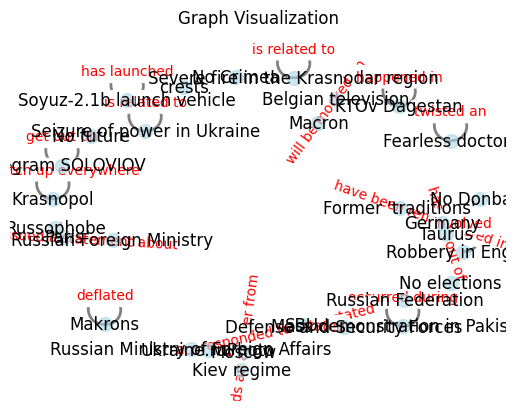

In [32]:
draw_graph(G)

In [33]:
nx.write_gml(G, 'test1.gml')

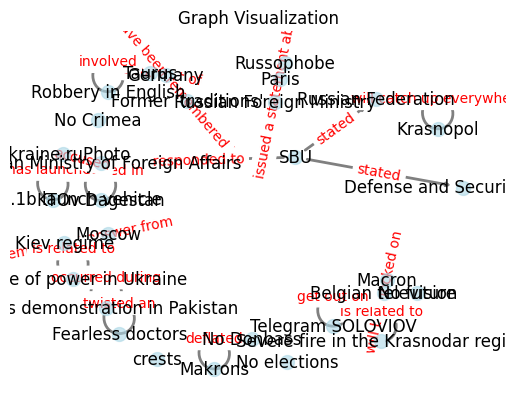

In [34]:
draw_graph(G)

In [35]:
# Display the graph
print("Nodes in the graph:")
print(G.nodes(data=True))

print("Edges in the graph:")
print(G.edges(data=True))

Nodes in the graph:
[('0400c828-c2a7-5021-8bae-1aadf3206e21_1', {'name': 'No elections', 'node_type': 'concept'}), ('0400c828-c2a7-5021-8bae-1aadf3206e21_2', {'name': 'No Crimea', 'node_type': 'concept'}), ('0400c828-c2a7-5021-8bae-1aadf3206e21_3', {'name': 'No Donbass', 'node_type': 'concept'}), ('0400c828-c2a7-5021-8bae-1aadf3206e21_4', {'name': 'No future', 'node_type': 'concept'}), ('0400c828-c2a7-5021-8bae-1aadf3206e21_5', {'name': 'crests', 'node_type': 'actor'}), ('05afd37e-b223-544b-9eb1-6486f7adac34_1', {'name': 'Moscow', 'node_type': 'actor'}), ('05afd37e-b223-544b-9eb1-6486f7adac34_2', {'name': 'Kiev regime', 'node_type': 'actor'}), ('05afd37e-b223-544b-9eb1-6486f7adac34_3', {'name': 'Krasnopol', 'node_type': 'event'}), ('05afd37e-b223-544b-9eb1-6486f7adac34_4', {'name': 'Seizure of power in Ukraine', 'node_type': 'event'}), ('05afd37e-b223-544b-9eb1-6486f7adac34_5', {'name': 'Macron', 'node_type': 'actor'}), ('05afd37e-b223-544b-9eb1-6486f7adac34_6', {'name': 'Belgian telev